In [1]:
import json
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pylab
import random
from skimage import transform
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap
random.seed(1)

In [2]:
# load data and visualize q and bbox
region_desc_name = '../data/data/datasets/vg/region/region_descriptions.json'
img_path = '../data/data/datasets/vg/images'
vg_boxes_name = '../data/data/datasets/vg/vg_boxes.npy'

region_desc_data = json.load(open(region_desc_name))
vg_boxes_data = np.load(vg_boxes_name, allow_pickle=True)

In [3]:
region_desc_data[0]
imgid_region_map = {i['id']:i['regions'] for i in region_desc_data}

In [4]:
vg_boxes_data[0]

{'image_path': 'VG_100K_2/1.jpg',
 'image_width': 800,
 'image_height': 600,
 'image_id': '1',
 'normalized_boxes': array([[0.52625   , 0.095     , 0.62875   , 0.32666665],
        [0.2425    , 0.62      , 0.47      , 0.8016667 ],
        [0.30125   , 0.8183333 , 0.3775    , 0.86833334],
        ...,
        [0.315     , 0.00166667, 0.9775    , 0.9316667 ],
        [0.10125   , 0.525     , 0.9875    , 0.99333334],
        [0.495     , 0.01      , 0.99      , 0.49833333]], dtype=float32)}

In [5]:
def display_img(pred_im_path, ocr_results, notes='vg'):
    plt.figure()
    im = cv2.imread(pred_im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)

    for res in ocr_results:
        bbox = res['bbox']
        txt = res['txt']
        plt.gca().add_patch(
            plt.Rectangle((bbox[0][0], bbox[0][1]),
                          bbox[1][0] - bbox[0][0],
                          bbox[1][1] - bbox[0][1], fill=False,
                          edgecolor='red', linewidth=2, alpha=0.5)
                )
        plt.gca().text(bbox[0][0], bbox[0][1] - 5,
                    '%s' % (txt),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=15, color='white')
    plt.gca().text(20,50, notes,
                    bbox=dict(facecolor='blue', alpha=0.9),
                    fontsize=30, color='white')

    
def post_process_results(results):
    outputs = [] # a list of dicts with keys "bbox","txt" 
    for i, res in enumerate(results):
        output = {'internal_index': i, 'txt':res['phrase'], 'bbox':[[res['x'], res['y']], 
                                               [res['x']+res['width'], res['y']+res['height']]]}
        outputs.append(output)

    return outputs

def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
#     scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
#     order = scores.argsort()[::-1]
    order = np.array(range(len(dets)))
    keep = []
    while len(order) > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

def remove_same_texts(reg_info):
    current_texts = set()
    ret = []
    for info in reg_info:
        if info["txt"] not in current_texts:
            ret.append(info)
            current_texts.add(info["txt"])
    return ret

def prepare_regions(box_info, nms_thresh=0.1, compare_display=False, return_number=False):
    region_info = imgid_region_map[int(box_info['image_id'])]
    region_info = post_process_results(region_info)
    if return_number:
        ori_number = len(region_info)
    if compare_display: 
        display_img(os.path.join(img_path, box_info['image_path']), region_info)
    
    region_info = remove_same_texts(region_info)
    all_regions = np.array([[i['bbox'][0][0],i['bbox'][0][1],i['bbox'][1][0],i['bbox'][1][1]] for i in region_info])
    # apply nms
    regions_needed = nms(all_regions, thresh=nms_thresh)
    region_info = [r for i, r in enumerate(region_info) if i in regions_needed]
    
    if compare_display:
        display_img(os.path.join(img_path, box_info['image_path']), region_info)
    if return_number:
        return region_info, ori_number, len(region_info)
    else:
        return region_info

108077


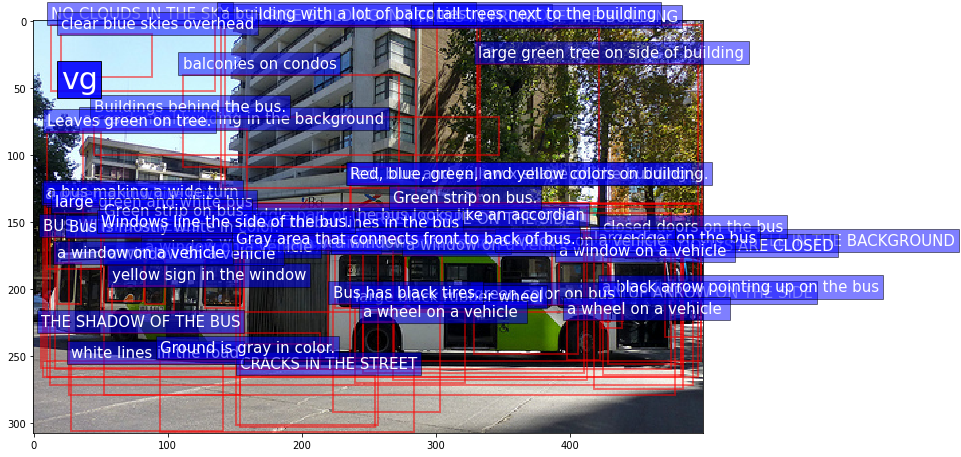

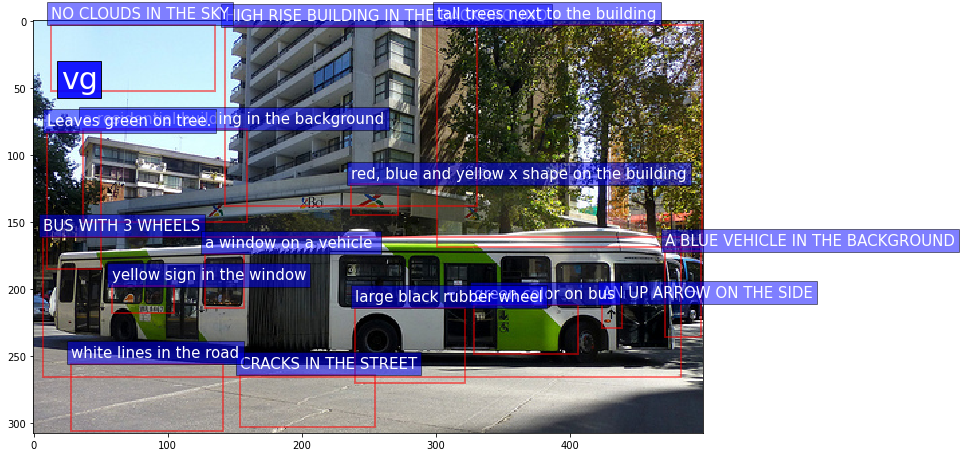

In [134]:
# randomly sample an image from vg_boxes_data
print(len(vg_boxes_data))
region_info = prepare_regions(random.choice(vg_boxes_data), compare_display=True)

In [6]:
# randomly sample an image from vg_boxes_data
from tqdm import tqdm
import copy
print(len(vg_boxes_data))
tot_ori = 0
tot_left = 0

filtered_info_list = []
with tqdm(vg_boxes_data) as prog:
    for box_info in prog:
        prog.set_description(f"Ori: {tot_ori}, Now: {tot_left}, rate: {(0. if tot_ori == 0 else tot_left / tot_ori):.4}")
        region_info, ori_num, current_num = prepare_regions(box_info, return_number=True)
        # filter box_info['normalized_boxes'] based on region_info, and add to f
        index_needed = [r['internal_index'] for r in region_info]
        box_info['all_normalized_boxes'] = copy.deepcopy(box_info['normalized_boxes'])
        box_info['normalized_boxes'] = box_info['normalized_boxes'][index_needed]
        box_info['index_needed'] = index_needed
        box_info['descriptions'] = region_info
        box_info['feature_path'] = box_info['image_path'].replace('/', '-').replace('.jpg', '.npy')
        filtered_info_list.append(box_info)
        tot_ori += ori_num
        tot_left += current_num
        


Ori: 8233, Now: 1530, rate: 0.1858:   0%|          | 35/108077 [00:00<05:18, 339.23it/s]

108077


Ori: 5408638, Now: 1511374, rate: 0.2794: 100%|██████████| 108077/108077 [03:54<00:00, 461.15it/s]


In [7]:
# save this file to a npy
info_tgt = '../data/data/datasets/vg/defaults/annotations/imdb_{}_nms_0.1_rm_dup_sent.npy'
train_set = filtered_info_list[:int(len(filtered_info_list)*0.8)]
val_set = filtered_info_list[int(len(filtered_info_list)*0.8):]
np.save(info_tgt.format('train'), train_set, allow_pickle=True)
np.save(info_tgt.format('val'), val_set, allow_pickle=True)


In [14]:
# filter frcnn feature and save to lmdb
src_frcnn_path = '../data/data/datasets/vg/vg_pretrain_v0_frcn_features/'
lmdb_name = '../data/data/datasets/vg/defaults/features/vg/detectron_nms_0.1_rm_dup_sent.lmdb'
img_path_frcnn_map = {}
for l in tqdm(filtered_info_list):
    feature_path = l['feature_path']
    fname = os.path.join(src_frcnn_path, feature_path)
    feats = np.load(fname)
    filtered_feats = feats[l['index_needed']]
    img_path_frcnn_map[feature_path] = filtered_feats

100%|██████████| 108077/108077 [00:31<00:00, 3463.20it/s]


In [9]:
import lmdb
import pickle

In [10]:
def dict_to_lmdb(out_path, dict_to_save):
    env = lmdb.open(out_path, map_size=3e10, writemap=True)
    with env.begin(write=True) as txn:
        keys = []
        for i, (k, v) in enumerate(dict_to_save.items()):
            assert txn.put(k.encode(), pickle.dumps(v)), 'failed to add {} into lmdb'.format(k)
            keys.append(k.encode())

        txn.put('keys'.encode(), pickle.dumps(keys))
        print("added {} records to the database".format(len(keys)))

In [19]:
dict_to_lmdb(lmdb_name, img_path_frcnn_map)

<ipython-input-10-e9b3d15bd29c>:2: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  env = lmdb.open(out_path, map_size=3e10, writemap=True)


added 108077 records to the database
